In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ColorJitter
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)


In [3]:
#dataset dimensions
print(train_set.data.size())
print(train_set.targets.size())
print(test_set.data.size())
print(test_set.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [4]:
class_names = datasets.FashionMNIST.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# classes distribution
classes = train_set.targets
class_count = torch.zeros(len(class_names))
for c in classes:
    class_count[c] += 1
print(class_count)


tensor([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.])


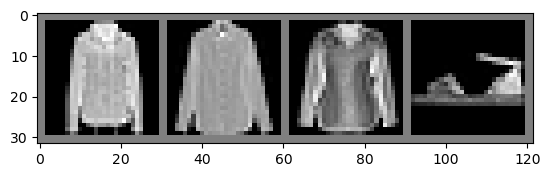

Coat
Shirt
Shirt
Sandal


In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
class_names = train_set.classes
for label in labels:
    print(class_names[label])


In [ ]:
# Define the network

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = CustomCNN()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
for epoch in range(20):  # Epoche di addestramento
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))

print('Addestramento completato')

In [ ]:
# test on test set
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

In [ ]:
#more complex custom cnn
class CustomNetComplex(nn.Module):
    def __init__(self):
        super(CustomNetComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # L'output del secondo max pooling sarà di dimensioni 7x7
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)  # Appiattimento prima dei layer fully connected
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_complex = CustomNetComplex()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_complex.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):  
    net_complex.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net_complex.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))

print('Training completed')

In [ ]:
net_complex.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

In [8]:
class CustomCNNComplex(nn.Module):
    def __init__(self):
        super(CustomCNNComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)  
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)
        return x

net_complex2 = CustomCNNComplex()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_complex2.parameters(), lr=0.001)

In [10]:
for epoch in range(20):  
    net_complex2.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net_complex2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy on validation set: {:.2f}%'.format(accuracy))

print('Training completed')

[1,   100] loss: 0.916
[1,   200] loss: 0.506
[1,   300] loss: 0.444
[1,   400] loss: 0.395
[1,   500] loss: 0.365
[1,   600] loss: 0.367
[1,   700] loss: 0.310
Accuracy on validation set: 89.56%
[2,   100] loss: 0.269
[2,   200] loss: 0.281
[2,   300] loss: 0.276
[2,   400] loss: 0.269
[2,   500] loss: 0.243
[2,   600] loss: 0.251
[2,   700] loss: 0.264
Accuracy on validation set: 91.48%
[3,   100] loss: 0.212
[3,   200] loss: 0.222
[3,   300] loss: 0.206
[3,   400] loss: 0.208
[3,   500] loss: 0.207
[3,   600] loss: 0.206
[3,   700] loss: 0.222
Accuracy on validation set: 92.42%
[4,   100] loss: 0.172
[4,   200] loss: 0.183
[4,   300] loss: 0.179
[4,   400] loss: 0.178
[4,   500] loss: 0.185
[4,   600] loss: 0.168
[4,   700] loss: 0.185
Accuracy on validation set: 92.23%
[5,   100] loss: 0.143
[5,   200] loss: 0.145
[5,   300] loss: 0.147
[5,   400] loss: 0.167
[5,   500] loss: 0.142
[5,   600] loss: 0.148
[5,   700] loss: 0.156
Accuracy on validation set: 92.75%
[6,   100] loss: 0.1

In [11]:
net_complex2.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex2(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())

# Calcola l'accuratezza utilizzando sklearn
accuracy = accuracy_score(true_labels, pred_labels) * 100
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 92.69%
